In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def citf(image):
    image = image.reshape((256,256))
    tmp = np.fft.fftshift(cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT))
    complex_matrix = tmp[:,:,0] + 1j * tmp[:,:,1]
    complex_matrix = complex_matrix.reshape((256,256,1))
    return complex_matrix

In [3]:
def cfti(kspace):
    kspace = kspace.reshape((256,256))
    img_inverse = np.flipud(np.fliplr(np.abs(np.fft.ifft2(kspace))))
    img_inverse = img_inverse.reshape((256,256,1))
    return img_inverse

In [4]:
def show_both(kspace):
    temp = kspace.reshape((256,256))
    mag_spe = 20*np.log(np.abs(temp))
    plt.subplot(121), plt.imshow(cfti(kspace).reshape((256,256)), cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(mag_spe, cmap='gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()

In [5]:
def diff(t_kspace , u_kspace):
    plt.subplot(121), plt.imshow(cfti(t_kspace).reshape((256,256)), cmap='gray')
    plt.title('Ground Truth'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(cfti(u_kspace).reshape((256,256)), cmap='gray')
    plt.title('Undersampled Image'), plt.xticks([]), plt.yticks([])
    plt.show()

In [9]:
images = []
def process_file(file_path):
    if "mask" in file_path or "README" in file_path or ".csv" in file_path:
        time.sleep(0)
    else:
        image = cv2.imread(file_path,0)
        image = np.array(image)
        image = image.reshape((256,256,1))
        image = image.astype('float32') / 255.0
        images.append(image)
        return
for folder_name, subfolders, filenames in os.walk("/kaggle/input/lgg-mri-segmentation/kaggle_3m"):
    for filename in filenames:
        if "mask" not in filename:
            file_path = os.path.join(folder_name, filename)
            process_file(file_path)
images = np.asarray(images)

In [10]:
images.shape

(3929, 256, 256, 1)

In [11]:
kspaces = []
for image in images:
    kspace = citf(image)
    kspaces.append(np.array(kspace))
kspaces = np.asarray(kspaces)

In [12]:
kspaces.shape

(3929, 256, 256, 1)

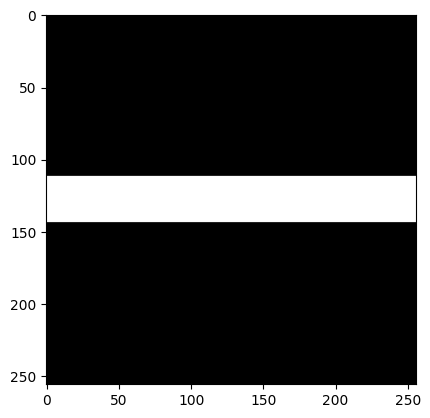

In [13]:
mask = np.zeros((256,256))
mask[112:144,:] = np.ones((32,256))
plt.imshow(mask, cmap='gray')

In [14]:
def unsample_data(data, mask):
    u_kspaces = []
    u_images = []
    for i in range(kspaces.shape[0]):
        u_kspace = np.multiply(kspaces[i,:,:].reshape(256,256), mask)
        u_kspace = u_kspace.reshape((256,256,1))
        u_kspaces.append(u_kspace)
        u_images.append(cfti(u_kspace))
    return np.array(u_kspaces) , np.array(u_images)

In [15]:
u_kspaces , u_images = unsample_data(kspaces,mask)

In [16]:
u_kspaces.shape

(3929, 256, 256, 1)

In [17]:
u_images.shape

(3929, 256, 256, 1)

In [ ]:
np.savez('data.npz',kspaces=kspaces , u_kspaces = u_kspaces , images=images , u_images=u_images)

In [ ]:
import numpy as np
data = np.load('/kaggle/working/data.npz')
kspaces = data['kspaces']
u_kspaces = data['u_kspaces']
images = data['images']
u_images = data['u_images']

In [ ]:
show_both(u_kspaces[101,:,:])

In [ ]:
diff(kspaces[100,:,:],u_kspaces[100,:,:])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(u_images , images , test_size=0.2, random_state=42)

In [19]:
import numpy as np 
import glob
import nibabel as nib 
import os
import pickle 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from skimage import measure
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import tensorflow as tf 
from tensorflow.keras.models import Model 
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Add 
from tensorflow.keras.layers import Concatenate, Activation 
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import RandomNormal 
# from keras.initializers import RandomNormal
# from tensorflow.python.keras.utils import multi_gpu_model

In [20]:
# loss for dicriminator 

def accw(y_true, y_pred):
    y_pred = K.clip(y_pred, -1 , 1)
    
    return K.mean (K.equal(y_true, K.round(y_pred)))


def mssim(y_true, y_pred):
    costs = 1.0 -tf.reduce_mean(tf.image.ssim(y_true,y_pred, 2.0))
    
    return costs 

def wloss(y_true, y_predict):
    
    return -K.mean(y_true+y_predict)


In [21]:
def discriminator(inp_shape = (256,256,1), trainable = True):
    gamma_init = RandomNormal(1. , 0.02)
    
    inp = Input(shape =(256,256,1))
    
    l0 = Conv2D(64, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(inp)
    l0 = LeakyReLU(alpha=0.2)(l0)
    
    l1 = Conv2D(64*2, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l0)
    l1 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l1)
    l1 = LeakyReLU(alpha=0.2)(l1)
    
    l2 = Conv2D(64*2, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l1)
    l2 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l2)
    l2 = LeakyReLU(alpha=0.2)(l2)
    
    l3 = Conv2D(64*8, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l2)
    l3 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l3)
    l3 = LeakyReLU(alpha=0.2)(l3)
    
    l4 = Conv2D(64*16, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l3)
    l4 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l4)
    l4 = LeakyReLU(alpha=0.2)(l4)
    
    l5 = Conv2D(64*32, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l4)
    l5 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l5)
    l5 = LeakyReLU(alpha=0.2)(l5)
    
    l6 = Conv2D(64*16, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l5)
    l6 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l6)
    l6 = LeakyReLU(alpha=0.2)(l6)
    
    l7 = Conv2D(64*8, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l6)
    l7 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l7)
    l7 = LeakyReLU(alpha=0.2)(l7)
    
    l8 = Conv2D(64*2, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l7)
    l8 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l8)
    l8 = LeakyReLU(alpha=0.2)(l8)
    
    l9 = Conv2D(64*2, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l8)
    l9 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l9)
    l9 = LeakyReLU(alpha=0.2)(l9)
    
    l10 = Conv2D(64*8, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l9)
    l10 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(l10)
    l10 = LeakyReLU(alpha=0.2)(l10)
    
    l11 = Add()([l7,l10])
    l11 = LeakyReLU(alpha = 0.2)(l11)
    
    out =  Conv2D(filters = 1, kernel_size = 3, strides = 1, padding= 'same',use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(l11)
    model = Model(inputs = inp, outputs = out )
    return model 

In [22]:
def resden(x,fil,gr,beta, gamma_init, trainable):
    
    x1 = Conv2D(filters=gr, kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(x)
    x1 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x1)
    x1 = LeakyReLU(alpha=0.2)(x1)
    
    x1 = Concatenate(axis = -1 )([x,x1])
    
    x2 = Conv2D(filters=gr, kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(x1)
    x2 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    
    x2 = Concatenate(axis = -1 )([x1,x2])
    
    x3 = Conv2D(filters=gr, kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(x2)
    x3 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x3)
    x3 = LeakyReLU(alpha=0.2)(x3)

    x3 = Concatenate(axis = -1 )([x2,x3])
    
    x4 = Conv2D(filters=gr, kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(x3)
    x4 = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(x4)
    x4 = LeakyReLU(alpha=0.2)(x4)
    
    x4 = Concatenate(axis = -1 )([x3,x4])
    
    x5 = Conv2D(filters=fil, kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(x4)
    x5 = Lambda(lambda x:x-beta)(x5)
    xout = Add()([x5,x])
    
    return xout 



In [23]:
def resresden(x,fil,gr,betad, betar, gamma_init, trainable):
    
    x1=resden(x,fil,gr,betad,gamma_init,trainable)
    x2=resden(x1,fil,gr,betad,gamma_init,trainable)
    x3=resden(x2,fil,gr,betad,gamma_init,trainable)
    x3=Lambda(lambda x:x-betar)(x3)
    xout = Add()([x3,x])
    
    return xout 



In [24]:
def generator(inp_shape, trainable = True):
    
    gamma_init = RandomNormal(1.,0.02)
    
    fd =512
    gr =32
    nb =12
    betad =0.2
    betar =0.2
    
    inp_real_imag = Input(inp_shape)
    lay_128dn =  Conv2D(64, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(inp_real_imag)
    lay_128dn = LeakyReLU(alpha=0.2)(lay_128dn)
    print("lay_128dn",lay_128dn.shape)
    
    lay_64dn =  Conv2D(128, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_128dn)
    lay_64dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_64dn)
    lay_64dn = LeakyReLU(alpha=0.2)(lay_64dn)
    print("lay_64dn",lay_64dn.shape)
    
    lay_32dn =  Conv2D(256, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_64dn)
    lay_32dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_32dn)
    lay_32dn = LeakyReLU(alpha=0.2)(lay_32dn)
    print("lay_32dn",lay_32dn.shape)
    
    lay_16dn =  Conv2D(512, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_32dn)
    lay_16dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_16dn)
    lay_16dn = LeakyReLU(alpha=0.2)(lay_16dn)
    print("lay_16dn",lay_16dn.shape)
    
    lay_8dn =  Conv2D(512, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_16dn)
    lay_8dn = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_8dn)
    lay_8dn = LeakyReLU(alpha=0.2)(lay_8dn)
    print("lay_8dn",lay_8dn.shape)
    
    xc1 =  Conv2D(filters=fd,kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_8dn)
    xrrd=xc1
    
    
    for m in range(nb):
        xrrd =  resresden(xrrd,fd,gr,betad, betar, gamma_init, trainable)
    
    xc2 = Conv2D(filters=fd,kernel_size=3, strides = 1, padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(xrrd)
    lay_8upc = Add()([xc1,xc2])
    
    lay_16up = Conv2DTranspose(1024, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_8upc)
    lay_16up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_16up)
    lay_16up = Activation('relu')(lay_16up)
    print("lay_16up",lay_16up.shape)
    
    lay_16upc = Concatenate(axis = -1)([lay_16up, lay_16dn])
    print(lay_16upc.shape)
    
    lay_32up =  Conv2DTranspose(256, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_16upc)
    lay_32up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_32up)
    lay_32up = Activation('relu')(lay_32up)
    print("lay_32up",lay_32up.shape)
    
    lay_32upc = Concatenate(axis = -1)([lay_32up, lay_32dn])
    
    lay_64up =  Conv2DTranspose(128, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_32upc)
    lay_64up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_64up)
    lay_64up = Activation('relu')(lay_64up)
    print("lay_64up",lay_64up.shape)
    
    lay_64upc = Concatenate(axis = -1)([lay_64up, lay_64dn])
    
    
    lay_128up =  Conv2DTranspose(64, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_64upc)
    lay_128up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_128up)
    lay_128up = Activation('relu')(lay_128up)
    print("lay_128up",lay_128up.shape)
    
    lay_128upc = Concatenate(axis = -1)([lay_128up, lay_128dn])
    
    lay_256up =  Conv2DTranspose(64, (4,4), strides = (2,2), padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_128upc)
    lay_256up = BatchNormalization(gamma_initializer = gamma_init, trainable = trainable)(lay_256up)
    lay_256up = Activation('relu')(lay_256up)
    print("lay_256up",lay_256up.shape)
    
    out = Conv2D(1, (1,1),strides =(1,1), activation = 'tanh', padding ='same', use_bias = True, kernel_initializer ='he_normal', bias_initializer = 'zeros')(lay_256up)
    
    model = Model(inputs =inp_real_imag, outputs = out )
    
    return model 

    

In [25]:
def define_gan_model(gen_model, dis_model, inp_shape):
    
    dis_model.trainable = False
    inp =Input(shape = inp_shape)
    out_g = gen_model(inp)
    
    out_dis = dis_model(out_g)
    
    out_g1 = out_g
    
    model = Model(inputs = inp, outputs =[out_dis, out_g, out_g1])
    
    model.summary()
    
    return model
    
    
    

In [26]:
def train(g_par, d_par, gan_model, dataset_real, u_sampled_data, n_epochs, n_batch, n_critic, clip_val, n_patch):
    
    bat_per_epo = 32
    half_batch = 16
    
    for i in range(n_epochs):
        print('Epochs', i)
        
        for j in range(bat_per_epo):
            
            print('Batch', j)
            
            for k in range(n_critic):
                ix = np.random.randint(0, dataset_real.shape[0], half_batch)
                
                X_real = dataset_real[ix]
                y_real = np.ones((half_batch, n_patch, n_patch, 1))
                
                ix_1 = np.random.randint(0, u_sampled_data.shape[0], half_batch)
                X_fake = g_par.predict(u_sampled_data[ix_1])
                y_fake = -np.ones((half_batch, n_patch, n_patch, 1))
                
                X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
                
                d_loss, accuracy = d_par.train_on_batch(X, y)
                
                for L in d_par.layers:
                    weights = L.get_weights()
                    weights = [np.clip(w, clip_val, clip_val) for w in weights]
                    L.set_weights(weights)
                    
            ix = np.random.randint(0, dataset_real.shape[0], n_batch)

            X_r = dataset_real[ix]
            
            X_gen_inp = u_sampled_data[ix]
            y_gan = np.ones((n_batch, n_patch, n_patch, 1))
            
            g_loss = gan_model.train_on_batch([X_gen_inp], [y_gan, X_r, X_r])
            
            print('>%d, %d/%d, d = %.3f, acc = %.3f, g = %.3f' % (i+1, j+1, bat_per_epo, d_loss, accuracy, g_loss[0]))
            g_par.save_weights("epoch50.h5")


                

In [27]:
somthing = np.concatenate((u_kspaces.real, u_kspaces.imag), axis = -1)

In [28]:
somthing.shape

(3929, 256, 256, 2)

In [ ]:
n_epochs = 50
n_batch = 32
n_critic = 3

clip_val =0.05
in_shape_gen = (256,256,2)
in_shape_dis = (256,256,1)
accel = 3

d_model = discriminator(inp_shape = in_shape_dis, trainable =True)

d_model.summary()

d_par = d_model
opt = Adam(lr = 0.0002, beta_1 =0.5)
d_par.compile(loss = wloss, optimizer = opt, metrics = [accw])

g_model = generator(inp_shape =in_shape_gen, trainable = True)

g_par =g_model
g_par.summary()

gan_model = define_gan_model(g_par, d_par, in_shape_gen)

opt1 = Adam(lr =0.0001 , beta_1 = 0.5)

gan_model.compile(loss =[wloss, 'mae', mssim], optimizer = opt1, loss_weights = [0.01, 20.0, 1.0])
n_patch = d_model.output_shape[1]

In [ ]:
train(g_par, d_par, gan_model, images ,somthing, n_epochs, n_batch, n_critic, clip_val, n_patch)

In [ ]:
new = g_par.predict(somthing)

In [30]:
g_model = generator(inp_shape =(256,256,2), trainable = False)

lay_128dn (None, 128, 128, 64)
lay_64dn (None, 64, 64, 128)
lay_32dn (None, 32, 32, 256)
lay_16dn (None, 16, 16, 512)
lay_8dn (None, 8, 8, 512)


/opt/conda/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


lay_16up (None, 16, 16, 1024)
(None, 16, 16, 1536)
lay_32up (None, 32, 32, 256)
lay_64up (None, 64, 64, 128)
lay_128up (None, 128, 128, 64)
lay_256up (None, 256, 256, 64)


In [31]:
g_model.load_weights('/kaggle/working/epoch50.h5')

In [32]:
new = g_model.predict(somthing)

123/123 [==============================] - 32s 170ms/step


In [33]:
new.shape

(3929, 256, 256, 1)

In [38]:
ne = new[10,:,:,:]

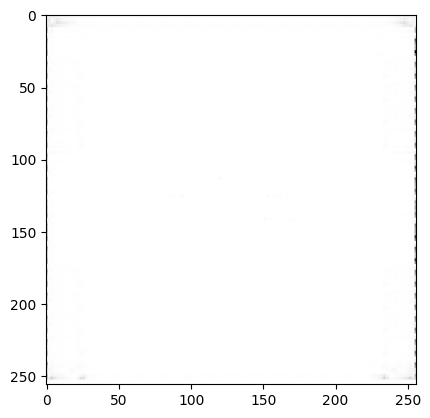

In [39]:
plt.imshow(ne.reshape((256,256)), cmap='gray')

**This model architechture was a failure as it is not giving any relevant images even after 50 epoches.**

**That is why we discarded this model and approach.**

# END OF MODEL 2